In [16]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Load data
try:
    df = pd.read_csv('/kaggle/input/datasets/samiuseskaggle/train-txt/train.txt', sep='\s+', names=['head', 'relation', 'tail'])
except:
    df = pd.read_csv('../The Problem/train.txt', sep='\s+', names=['head', 'relation', 'tail'])

print(f"Total triples: {len(df)}")
print(f"Unique relations: {df['relation'].nunique()}")

# Build edge set
all_edges = set(zip(df['head'], df['relation'], df['tail']))
print(f"Unique edges: {len(all_edges)}")

# Infer gender
male_relations = {'fatherOf', 'brotherOf', 'sonOf', 'uncleOf', 'nephewOf', 
                  'grandfatherOf', 'grandsonOf', 'greatGrandfatherOf', 'greatGrandsonOf',
                  'greatUncleOf', 'boyCousinOf', 'boyFirstCousinOnceRemovedOf', 'boySecondCousinOf',
                  'secondUncleOf'}
female_relations = {'motherOf', 'sisterOf', 'daughterOf', 'auntOf', 'nieceOf',
                    'grandmotherOf', 'granddaughterOf', 'greatGrandmotherOf', 'greatGranddaughterOf',
                    'greatAuntOf', 'girlCousinOf', 'girlFirstCousinOnceRemovedOf', 'girlSecondCousinOf',
                    'secondAuntOf'}

gender = {}
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in male_relations:
        gender[h] = 'M'
    elif r in female_relations:
        gender[h] = 'F'

print(f"Gender inferred: {len(gender)} ({sum(1 for g in gender.values() if g == 'M')}M, {sum(1 for g in gender.values() if g == 'F')}F)")

Total triples: 13821
Unique relations: 28
Unique edges: 13821
Gender inferred: 1316 (646M, 670F)


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_55/1908426683.py:12: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('/kaggle/input/datasets/samiuseskaggle/train-txt/train.txt', sep='\s+', names=['head', 'relation', 'tail'])
/tmp/ipykernel_55/1908426683.py:14: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('../The Problem/train.txt', sep='\s+', names=['head', 'relation', 'tail'])


In [17]:
# === STEP 1: IDENTIFY THE AXIOM SET ===
# Hypothesis: Parent-child edges are the ONLY primitive relations.
# Everything else (siblings, grandparents, cousins, etc.) can be DERIVED.

# Build parent→child directed graph
parent_child_relations = {'fatherOf', 'motherOf'}
child_parent_relations = {'sonOf', 'daughterOf'}

# Normalize to parent→child direction
axiom_edges = set()  # Normalized: (parent, child) pairs
axiom_triples = set()  # Original triples

for h, r, t in all_edges:
    if r in parent_child_relations:
        axiom_edges.add((h, t))  # parent→child
        axiom_triples.add((h, r, t))
    elif r in child_parent_relations:
        axiom_edges.add((t, h))  # flip: parent→child
        axiom_triples.add((h, r, t))

print(f"Axiom triples (parent-child edges in both directions): {len(axiom_triples)}")
print(f"Unique parent→child pairs: {len(axiom_edges)}")
print(f"Non-axiom edges to derive: {len(all_edges) - len(axiom_triples)}")

# Build lookup structures from axioms
parent_to_children = defaultdict(set)
child_to_parents = defaultdict(set)

for parent, child in axiom_edges:
    parent_to_children[parent].add(child)
    child_to_parents[child].add(parent)

print(f"\nPeople who are parents: {len(parent_to_children)}")
print(f"People who have parents recorded: {len(child_to_parents)}")

Axiom triples (parent-child edges in both directions): 2694
Unique parent→child pairs: 1642
Non-axiom edges to derive: 11127

People who are parents: 890
People who have parents recorded: 821


In [18]:
# === STEP 2: DERIVE SIBLING RELATIONS ===
# Rule: If parent(P, A) and parent(P, B) and A ≠ B → sibling(A, B)

derived_siblings = set()

for parent, children in parent_to_children.items():
    children_list = list(children)
    for i in range(len(children_list)):
        for j in range(len(children_list)):
            if i != j:
                a, b = children_list[i], children_list[j]
                a_gender = gender.get(a, 'U')
                if a_gender == 'M':
                    derived_siblings.add((a, 'brotherOf', b))
                elif a_gender == 'F':
                    derived_siblings.add((a, 'sisterOf', b))

# Check against actual edges
actual_siblings = {(h, r, t) for h, r, t in all_edges if r in ['brotherOf', 'sisterOf']}
matched_siblings = derived_siblings & actual_siblings
extra_siblings = derived_siblings - actual_siblings
missed_siblings = actual_siblings - derived_siblings

print(f"SIBLING DERIVATION:")
print(f"  Derived: {len(derived_siblings)}")
print(f"  Actual:  {len(actual_siblings)}")
print(f"  Matched: {len(matched_siblings)} ({len(matched_siblings)/max(len(actual_siblings),1)*100:.1f}%)")
print(f"  Extra (derived but not in KG): {len(extra_siblings)}")
print(f"  Missed (in KG but not derived): {len(missed_siblings)}")

if missed_siblings:
    print(f"\n  Examples of missed siblings:")
    for edge in list(missed_siblings)[:5]:
        print(f"    {edge}")

SIBLING DERIVATION:
  Derived: 1206
  Actual:  1206
  Matched: 1206 (100.0%)
  Extra (derived but not in KG): 0
  Missed (in KG but not derived): 0


In [19]:
# === STEP 3: DERIVE GRANDPARENT RELATIONS ===
# Rule: parent(GP, P) ∧ parent(P, C) → grandparent(GP, C)

derived_grandparents = set()

for child, parents in child_to_parents.items():
    for parent in parents:
        if parent in child_to_parents:
            grandparents = child_to_parents[parent]
            for gp in grandparents:
                gp_gender = gender.get(gp, 'U')
                child_gender = gender.get(child, 'U')
                
                if gp_gender == 'M':
                    derived_grandparents.add((gp, 'grandfatherOf', child))
                elif gp_gender == 'F':
                    derived_grandparents.add((gp, 'grandmotherOf', child))
                
                if child_gender == 'M':
                    derived_grandparents.add((child, 'grandsonOf', gp))
                elif child_gender == 'F':
                    derived_grandparents.add((child, 'granddaughterOf', gp))

actual_grandparents = {(h, r, t) for h, r, t in all_edges 
                       if r in ['grandfatherOf', 'grandmotherOf', 'grandsonOf', 'granddaughterOf']}
matched_gp = derived_grandparents & actual_grandparents
missed_gp = actual_grandparents - derived_grandparents

print(f"GRANDPARENT DERIVATION:")
print(f"  Derived: {len(derived_grandparents)}")
print(f"  Actual:  {len(actual_grandparents)}")
print(f"  Matched: {len(matched_gp)} ({len(matched_gp)/max(len(actual_grandparents),1)*100:.1f}%)")
print(f"  Missed:  {len(missed_gp)}")

GRANDPARENT DERIVATION:
  Derived: 3252
  Actual:  3252
  Matched: 3252 (100.0%)
  Missed:  0


In [20]:
# === STEP 4: DERIVE UNCLE/AUNT RELATIONS ===
# Rule: parent(P, C) ∧ sibling(P, S) → uncle/aunt(S, C) ∧ nephew/niece(C, S)
# But sibling is already derived from shared parents, so:
# Rule: parent(GP, P) ∧ parent(GP, S) ∧ P≠S ∧ parent(P, C) → uncle/aunt(S, C)

derived_uncle_aunt = set()

for child, parents in child_to_parents.items():
    for parent in parents:
        # Find parent's siblings (share at least one grandparent)
        if parent in child_to_parents:
            parent_parents = child_to_parents[parent]
            for grandparent in parent_parents:
                for parent_sibling in parent_to_children[grandparent]:
                    if parent_sibling != parent:
                        ps_gender = gender.get(parent_sibling, 'U')
                        child_gender = gender.get(child, 'U')
                        
                        if ps_gender == 'M':
                            derived_uncle_aunt.add((parent_sibling, 'uncleOf', child))
                        elif ps_gender == 'F':
                            derived_uncle_aunt.add((parent_sibling, 'auntOf', child))
                        
                        if child_gender == 'M':
                            derived_uncle_aunt.add((child, 'nephewOf', parent_sibling))
                        elif child_gender == 'F':
                            derived_uncle_aunt.add((child, 'nieceOf', parent_sibling))

actual_ua = {(h, r, t) for h, r, t in all_edges 
             if r in ['uncleOf', 'auntOf', 'nephewOf', 'nieceOf']}
matched_ua = derived_uncle_aunt & actual_ua
missed_ua = actual_ua - derived_uncle_aunt

print(f"UNCLE/AUNT/NEPHEW/NIECE DERIVATION:")
print(f"  Derived: {len(derived_uncle_aunt)}")
print(f"  Actual:  {len(actual_ua)}")
print(f"  Matched: {len(matched_ua)} ({len(matched_ua)/max(len(actual_ua),1)*100:.1f}%)")
print(f"  Missed:  {len(missed_ua)}")

if missed_ua:
    print(f"\n  Examples of missed uncle/aunt edges:")
    for edge in list(missed_ua)[:5]:
        h, r, t = edge
        print(f"    ({h}, {r}, {t}) | {h} parents: {child_to_parents.get(h, 'none')}, {t} parents: {child_to_parents.get(t, 'none')}")

UNCLE/AUNT/NEPHEW/NIECE DERIVATION:
  Derived: 2020
  Actual:  2020
  Matched: 2020 (100.0%)
  Missed:  0


In [21]:
# === STEP 5: DERIVE COUSIN RELATIONS ===
# Rule: parent(GP, P1) ∧ parent(GP, P2) ∧ P1≠P2 ∧ parent(P1, C1) ∧ parent(P2, C2)
#       → cousin(C1, C2)

derived_cousins = set()

for child, parents in child_to_parents.items():
    for parent in parents:
        if parent in child_to_parents:
            parent_parents = child_to_parents[parent]
            for grandparent in parent_parents:
                # All aunts/uncles (parent's siblings)
                for parent_sibling in parent_to_children[grandparent]:
                    if parent_sibling != parent:
                        # All cousins (aunt/uncle's children)
                        for cousin in parent_to_children.get(parent_sibling, set()):
                            child_gender = gender.get(child, 'U')
                            if child_gender == 'M':
                                derived_cousins.add((child, 'boyCousinOf', cousin))
                            elif child_gender == 'F':
                                derived_cousins.add((child, 'girlCousinOf', cousin))

actual_cousins = {(h, r, t) for h, r, t in all_edges 
                  if r in ['boyCousinOf', 'girlCousinOf']}
matched_cousins = derived_cousins & actual_cousins
missed_cousins = actual_cousins - derived_cousins

print(f"FIRST COUSIN DERIVATION:")
print(f"  Derived: {len(derived_cousins)}")
print(f"  Actual:  {len(actual_cousins)}")
print(f"  Matched: {len(matched_cousins)} ({len(matched_cousins)/max(len(actual_cousins),1)*100:.1f}%)")
print(f"  Missed:  {len(missed_cousins)}")

FIRST COUSIN DERIVATION:
  Derived: 836
  Actual:  836
  Matched: 836 (100.0%)
  Missed:  0


In [22]:
# === STEP 6: DERIVE GREAT-GRANDPARENT RELATIONS ===
# Rule: parent(GGP, GP) ∧ parent(GP, P) ∧ parent(P, C) → great-grandparent(GGP, C)

derived_great_gp = set()

for child, parents in child_to_parents.items():
    for parent in parents:
        if parent in child_to_parents:
            grandparents = child_to_parents[parent]
            for gp in grandparents:
                if gp in child_to_parents:
                    great_grandparents = child_to_parents[gp]
                    for ggp in great_grandparents:
                        ggp_gender = gender.get(ggp, 'U')
                        child_gender = gender.get(child, 'U')
                        
                        if ggp_gender == 'M':
                            derived_great_gp.add((ggp, 'greatGrandfatherOf', child))
                        elif ggp_gender == 'F':
                            derived_great_gp.add((ggp, 'greatGrandmotherOf', child))
                        
                        if child_gender == 'M':
                            derived_great_gp.add((child, 'greatGrandsonOf', ggp))
                        elif child_gender == 'F':
                            derived_great_gp.add((child, 'greatGranddaughterOf', ggp))

actual_ggp = {(h, r, t) for h, r, t in all_edges 
              if r in ['greatGrandfatherOf', 'greatGrandmotherOf', 'greatGrandsonOf', 'greatGranddaughterOf']}
matched_ggp = derived_great_gp & actual_ggp
missed_ggp = actual_ggp - derived_great_gp

print(f"GREAT-GRANDPARENT DERIVATION:")
print(f"  Derived: {len(derived_great_gp)}")
print(f"  Actual:  {len(actual_ggp)}")
print(f"  Matched: {len(matched_ggp)} ({len(matched_ggp)/max(len(actual_ggp),1)*100:.1f}%)")
print(f"  Missed:  {len(missed_ggp)}")

GREAT-GRANDPARENT DERIVATION:
  Derived: 2468
  Actual:  2468
  Matched: 2468 (100.0%)
  Missed:  0


In [23]:
# === STEP 7: DERIVE GREAT-UNCLE/AUNT RELATIONS ===
# Rule: grandparent(GP, C) ∧ sibling(GP, S) → great-uncle/aunt(S, C)
# Equivalently: parent(GGP, GP) ∧ parent(GGP, S) ∧ GP≠S ∧ parent(GP, P) ∧ parent(P, C)

derived_great_ua = set()

for child, parents in child_to_parents.items():
    for parent in parents:
        if parent in child_to_parents:
            grandparents = child_to_parents[parent]
            for gp in grandparents:
                if gp in child_to_parents:
                    great_grandparents = child_to_parents[gp]
                    for ggp in great_grandparents:
                        # Great-uncle/aunt = sibling of grandparent = other children of great-grandparent
                        for gp_sibling in parent_to_children[ggp]:
                            if gp_sibling != gp:
                                gs_gender = gender.get(gp_sibling, 'U')
                                if gs_gender == 'M':
                                    derived_great_ua.add((gp_sibling, 'greatUncleOf', child))
                                elif gs_gender == 'F':
                                    derived_great_ua.add((gp_sibling, 'greatAuntOf', child))

actual_great_ua = {(h, r, t) for h, r, t in all_edges 
                   if r in ['greatUncleOf', 'greatAuntOf']}
matched_great_ua = derived_great_ua & actual_great_ua
missed_great_ua = actual_great_ua - derived_great_ua

print(f"GREAT-UNCLE/AUNT DERIVATION:")
print(f"  Derived: {len(derived_great_ua)}")
print(f"  Actual:  {len(actual_great_ua)}")
print(f"  Matched: {len(matched_great_ua)} ({len(matched_great_ua)/max(len(actual_great_ua),1)*100:.1f}%)")
print(f"  Missed:  {len(missed_great_ua)}")

GREAT-UNCLE/AUNT DERIVATION:
  Derived: 549
  Actual:  549
  Matched: 549 (100.0%)
  Missed:  0


In [24]:
# === STEP 8: DERIVE SECOND UNCLE/AUNT ===
# Second uncle/aunt = parent's cousin = parent's parent's sibling's child
# Rule: parent(P, C) ∧ cousin(P, X) → secondUncle/Aunt(X, C)
# Expanded: parent(GP, P) ∧ parent(GP2, P_parent_sibling) ∧ shared_grandparent(GP, GP2)
#           ∧ parent(P_parent_sibling, X) ∧ parent(P, C) → secondUncle/Aunt(X, C)

# Actually simpler: second uncle/aunt of C = cousin of C's parent
# cousin(P, X): P and X share a grandparent but not a parent

derived_second_ua = set()

for child, parents in child_to_parents.items():
    for parent in parents:
        # Find parent's cousins
        if parent in child_to_parents:
            parent_parents = child_to_parents[parent]
            for gp in parent_parents:
                if gp in child_to_parents:
                    great_gps = child_to_parents[gp]
                    for ggp in great_gps:
                        for gp_sibling in parent_to_children[ggp]:
                            if gp_sibling != gp:
                                for parent_cousin in parent_to_children.get(gp_sibling, set()):
                                    pc_gender = gender.get(parent_cousin, 'U')
                                    if pc_gender == 'M':
                                        derived_second_ua.add((parent_cousin, 'secondUncleOf', child))
                                    elif pc_gender == 'F':
                                        derived_second_ua.add((parent_cousin, 'secondAuntOf', child))

actual_second_ua = {(h, r, t) for h, r, t in all_edges 
                    if r in ['secondUncleOf', 'secondAuntOf']}
matched_second_ua = derived_second_ua & actual_second_ua
missed_second_ua = actual_second_ua - derived_second_ua

print(f"SECOND UNCLE/AUNT DERIVATION:")
print(f"  Derived: {len(derived_second_ua)}")
print(f"  Actual:  {len(actual_second_ua)}")
print(f"  Matched: {len(matched_second_ua)} ({len(matched_second_ua)/max(len(actual_second_ua),1)*100:.1f}%)")
print(f"  Missed:  {len(missed_second_ua)}")

SECOND UNCLE/AUNT DERIVATION:
  Derived: 333
  Actual:  333
  Matched: 333 (100.0%)
  Missed:  0


In [25]:
# === STEP 9: DERIVE FIRST COUSIN ONCE REMOVED ===
# First cousin once removed of C = child of C's parent's cousin
# OR = C's cousin's child
# Rule: cousin(P, X) ∧ parent(X, Y) → firstCousinOnceRemoved(C, Y) where parent(P, C)

derived_fc1r = set()

for child, parents in child_to_parents.items():
    for parent in parents:
        if parent in child_to_parents:
            parent_parents = child_to_parents[parent]
            for gp in parent_parents:
                for parent_sibling in parent_to_children[gp]:
                    if parent_sibling != parent:
                        for cousin in parent_to_children.get(parent_sibling, set()):
                            # cousin's children are first cousins once removed
                            for cousin_child in parent_to_children.get(cousin, set()):
                                child_gender = gender.get(child, 'U')
                                if child_gender == 'M':
                                    derived_fc1r.add((child, 'boyFirstCousinOnceRemovedOf', cousin_child))
                                elif child_gender == 'F':
                                    derived_fc1r.add((child, 'girlFirstCousinOnceRemovedOf', cousin_child))

actual_fc1r = {(h, r, t) for h, r, t in all_edges 
               if r in ['boyFirstCousinOnceRemovedOf', 'girlFirstCousinOnceRemovedOf']}
matched_fc1r = derived_fc1r & actual_fc1r
missed_fc1r = actual_fc1r - derived_fc1r

print(f"FIRST COUSIN ONCE REMOVED DERIVATION:")
print(f"  Derived: {len(derived_fc1r)}")
print(f"  Actual:  {len(actual_fc1r)}")
print(f"  Matched: {len(matched_fc1r)} ({len(matched_fc1r)/max(len(actual_fc1r),1)*100:.1f}%)")
print(f"  Missed:  {len(missed_fc1r)}")

# === STEP 10: DERIVE SECOND COUSINS ===
# Second cousins: share great-grandparents but not grandparents
# C1 and C2 are second cousins if their parents are first cousins

derived_second_cousins = set()

for child, parents in child_to_parents.items():
    for parent in parents:
        if parent in child_to_parents:
            parent_parents = child_to_parents[parent]
            for gp in parent_parents:
                if gp in child_to_parents:
                    great_gps = child_to_parents[gp]
                    for ggp in great_gps:
                        for gp_sibling in parent_to_children[ggp]:
                            if gp_sibling != gp:
                                for parent_cousin in parent_to_children.get(gp_sibling, set()):
                                    for second_cousin in parent_to_children.get(parent_cousin, set()):
                                        child_gender = gender.get(child, 'U')
                                        if child_gender == 'M':
                                            derived_second_cousins.add((child, 'boySecondCousinOf', second_cousin))
                                        elif child_gender == 'F':
                                            derived_second_cousins.add((child, 'girlSecondCousinOf', second_cousin))

actual_sc = {(h, r, t) for h, r, t in all_edges 
             if r in ['boySecondCousinOf', 'girlSecondCousinOf']}
matched_sc = derived_second_cousins & actual_sc
missed_sc = actual_sc - derived_second_cousins

print(f"\nSECOND COUSIN DERIVATION:")
print(f"  Derived: {len(derived_second_cousins)}")
print(f"  Actual:  {len(actual_sc)}")
print(f"  Matched: {len(matched_sc)} ({len(matched_sc)/max(len(actual_sc),1)*100:.1f}%)")
print(f"  Missed:  {len(missed_sc)}")

FIRST COUSIN ONCE REMOVED DERIVATION:
  Derived: 333
  Actual:  333
  Matched: 0 (0.0%)
  Missed:  333

SECOND COUSIN DERIVATION:
  Derived: 130
  Actual:  130
  Matched: 130 (100.0%)
  Missed:  0


In [26]:
# === TRYING TO DEBUG: Why do we derive 333 but match 0? ===
# Let's look at what we derived vs what's actually in the KG

derived_fc1r_list = list(derived_fc1r)[:5]
actual_fc1r_list = list(actual_fc1r)[:5]

print("DERIVED examples:")
for h, r, t in derived_fc1r_list:
    print(f"  ({h}, {r}, {t})")

print("\nACTUAL examples:")
for h, r, t in actual_fc1r_list:
    print(f"  ({h}, {r}, {t})")

# Check: are we getting the direction backwards?
# Maybe firstCousinOnceRemoved(A, B) means A is the OLDER generation
# Let's check generations
import networkx as nx

# Build time graph for generation computation
time_graph = nx.DiGraph()
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in ['fatherOf', 'motherOf']:
        time_graph.add_edge(h, t)
    elif r in ['sonOf', 'daughterOf']:
        time_graph.add_edge(t, h)

generations = {}
roots = [n for n in time_graph.nodes() if time_graph.in_degree(n) == 0]
for root in roots:
    generations[root] = 0
for node in nx.topological_sort(time_graph):
    if node not in generations:
        parents = list(time_graph.predecessors(node))
        if parents:
            generations[node] = max(generations.get(p, 0) for p in parents) + 1
        else:
            generations[node] = 0

# Check generation pattern in actual edges
print("\nACTUAL firstCousinOnceRemoved - generation pattern:")
gen_patterns = []
for h, r, t in list(actual_fc1r)[:20]:
    h_gen = generations.get(h, -1)
    t_gen = generations.get(t, -1)
    diff = h_gen - t_gen
    gen_patterns.append(diff)
    print(f"  ({h}[gen{h_gen}], {r}, {t}[gen{t_gen}]) | head-tail = {diff}")

print(f"\nGeneration diff pattern: {Counter(gen_patterns)}")

print("\nDERIVED firstCousinOnceRemoved - generation pattern:")
gen_patterns_derived = []
for h, r, t in list(derived_fc1r)[:20]:
    h_gen = generations.get(h, -1)
    t_gen = generations.get(t, -1)
    diff = h_gen - t_gen
    gen_patterns_derived.append(diff)
    print(f"  ({h}[gen{h_gen}], {r}, {t}[gen{t_gen}]) | head-tail = {diff}")

print(f"\nGeneration diff pattern: {Counter(gen_patterns_derived)}")

DERIVED examples:
  (lea937, girlFirstCousinOnceRemovedOf, tobias941)
  (noah128, boyFirstCousinOnceRemovedOf, marlene127)
  (fabian140, boyFirstCousinOnceRemovedOf, lara150)
  (magdalena1236, girlFirstCousinOnceRemovedOf, jonathan1233)
  (michael312, boyFirstCousinOnceRemovedOf, theodor298)

ACTUAL examples:
  (magdalena350, girlFirstCousinOnceRemovedOf, raphael362)
  (lena18, girlFirstCousinOnceRemovedOf, olivia0)
  (lisa5, girlFirstCousinOnceRemovedOf, jonas23)
  (laura345, girlFirstCousinOnceRemovedOf, raphael362)
  (lisa5, girlFirstCousinOnceRemovedOf, leon16)

ACTUAL firstCousinOnceRemoved - generation pattern:
  (magdalena350[gen3], girlFirstCousinOnceRemovedOf, raphael362[gen2]) | head-tail = 1
  (lena18[gen3], girlFirstCousinOnceRemovedOf, olivia0[gen2]) | head-tail = 1
  (lisa5[gen3], girlFirstCousinOnceRemovedOf, jonas23[gen2]) | head-tail = 1
  (laura345[gen3], girlFirstCousinOnceRemovedOf, raphael362[gen2]) | head-tail = 1
  (lisa5[gen3], girlFirstCousinOnceRemovedOf, leon

In [27]:
# === FIX: First Cousin Once Removed direction is FLIPPED ===
# ACTUAL:  (younger[gen3], firstCousinOnceRemovedOf, older[gen2])  → head-tail = +1
# DERIVED: (older[gen2], firstCousinOnceRemovedOf, younger[gen3])  → head-tail = -1
#
# The KG convention: the CHILD of the cousin is the HEAD
# i.e., "I am firstCousinOnceRemovedOf my parent's cousin"
# NOT "my parent's cousin is firstCousinOnceRemovedOf me"

# We were deriving: for each child C, find parent P's cousin X, 
# then C is firstCousinOnceRemoved of X's CHILDREN
# But the KG says: X's children are firstCousinOnceRemoved of C's PARENT (the older generation)

# Fix: swap the direction
# The cousin's CHILD should be head, pointing to the PARENT's generation

derived_fc1r_fixed = set()

for child, parents in child_to_parents.items():
    for parent in parents:
        if parent in child_to_parents:
            parent_parents = child_to_parents[parent]
            for gp in parent_parents:
                for parent_sibling in parent_to_children[gp]:
                    if parent_sibling != parent:
                        for cousin in parent_to_children.get(parent_sibling, set()):
                            # cousin's children are firstCousinOnceRemoved of CHILD
                            # Direction: cousin_child → child (younger points to older)
                            for cousin_child in parent_to_children.get(cousin, set()):
                                cc_gender = gender.get(cousin_child, 'U')
                                if cc_gender == 'M':
                                    derived_fc1r_fixed.add((cousin_child, 'boyFirstCousinOnceRemovedOf', child))
                                elif cc_gender == 'F':
                                    derived_fc1r_fixed.add((cousin_child, 'girlFirstCousinOnceRemovedOf', child))

matched_fc1r_fixed = derived_fc1r_fixed & actual_fc1r
missed_fc1r_fixed = actual_fc1r - derived_fc1r_fixed

print(f"FIRST COUSIN ONCE REMOVED (FIXED):")
print(f"  Derived: {len(derived_fc1r_fixed)}")
print(f"  Actual:  {len(actual_fc1r)}")
print(f"  Matched: {len(matched_fc1r_fixed)} ({len(matched_fc1r_fixed)/max(len(actual_fc1r),1)*100:.1f}%)")
print(f"  Missed:  {len(missed_fc1r_fixed)}")

# Verify generation pattern
print("\nFIXED generation pattern (first 10):")
for h, r, t in list(derived_fc1r_fixed)[:10]:
    h_gen = generations.get(h, -1)
    t_gen = generations.get(t, -1)
    print(f"  ({h}[gen{h_gen}], {r}, {t}[gen{t_gen}]) | head-tail = {h_gen - t_gen}")

FIRST COUSIN ONCE REMOVED (FIXED):
  Derived: 333
  Actual:  333
  Matched: 333 (100.0%)
  Missed:  0

FIXED generation pattern (first 10):
  (magdalena350[gen3], girlFirstCousinOnceRemovedOf, raphael362[gen2]) | head-tail = 1
  (lena18[gen3], girlFirstCousinOnceRemovedOf, olivia0[gen2]) | head-tail = 1
  (lisa5[gen3], girlFirstCousinOnceRemovedOf, jonas23[gen2]) | head-tail = 1
  (lisa5[gen3], girlFirstCousinOnceRemovedOf, leon16[gen2]) | head-tail = 1
  (laura345[gen3], girlFirstCousinOnceRemovedOf, raphael362[gen2]) | head-tail = 1
  (selina185[gen3], girlFirstCousinOnceRemovedOf, rene205[gen2]) | head-tail = 1
  (claudia1300[gen4], girlFirstCousinOnceRemovedOf, moritz1298[gen3]) | head-tail = 1
  (natalie778[gen3], girlFirstCousinOnceRemovedOf, johanna781[gen2]) | head-tail = 1
  (valentin1259[gen6], boyFirstCousinOnceRemovedOf, alina1263[gen5]) | head-tail = 1
  (nico91[gen3], boyFirstCousinOnceRemovedOf, marlene86[gen2]) | head-tail = 1


In [28]:
# === GRAND SUMMARY  ===

# Recombine all derived edges with fix
all_derived_fixed = (derived_siblings | derived_grandparents | derived_uncle_aunt | 
                     derived_cousins | derived_great_gp | derived_great_ua | 
                     derived_second_ua | derived_fc1r_fixed | derived_second_cousins)

reconstructed_fixed = axiom_triples | all_derived_fixed
matched_fixed = reconstructed_fixed & all_edges
missed_fixed = all_edges - reconstructed_fixed

print("=" * 70)
print("KG COMPRESSION: FINAL RECONSTRUCTION REPORT")
print("=" * 70)
print(f"\nOriginal KG:         {len(all_edges)} edges (28 relation types)")
print(f"Axiom set:           {len(axiom_triples)} edges (4 relation types)")
print(f"Derived edges:       {len(all_derived_fixed)} edges (24 relation types)")
print(f"\nReconstructed:       {len(matched_fixed)} / {len(all_edges)} edges")
print(f"Reconstruction rate: {len(matched_fixed)/len(all_edges)*100:.2f}%")
print(f"Missed edges:        {len(missed_fixed)}")
print(f"\n{'='*70}")
print(f"COMPRESSION METRICS:")
print(f"{'='*70}")
print(f"  Axioms needed:       {len(axiom_triples)} edges")
print(f"  Original KG:         {len(all_edges)} edges")
print(f"  Compression ratio:   {len(axiom_triples)/len(all_edges)*100:.1f}%")
print(f"  Compression factor:  {len(all_edges)/len(axiom_triples):.1f}x")
print(f"  Redundancy:          {(1 - len(axiom_triples)/len(all_edges))*100:.1f}%")

# Per-relation breakdown
print(f"\n{'='*70}")
print(f"{'Relation':<37} {'Actual':>7} {'Matched':>8} {'Rate':>7}")
print(f"{'='*70}")

all_perfect = True
for rel in sorted(df['relation'].unique()):
    actual = {(h, r, t) for h, r, t in all_edges if r == rel}
    derived = {(h, r, t) for h, r, t in all_derived_fixed if r == rel}
    axiom = {(h, r, t) for h, r, t in axiom_triples if r == rel}
    combined = derived | axiom
    matched = combined & actual
    rate = len(matched)/len(actual)*100 if actual else 0
    
    tag = " [AXIOM]" if rel in {'fatherOf', 'motherOf', 'sonOf', 'daughterOf'} else ""
    status = "True" if rate == 100 else "False"
    print(f"  {status} {rel + tag:<35} {len(actual):>7} {len(matched):>8} {rate:>6.1f}%")
    
    if rate < 100:
        all_perfect = False

print(f"\n{'='*70}")
if all_perfect:
    print(" PERFECT RECONSTRUCTION: Every single edge derived from parent-child axioms!")
else:
    print(f"Missed {len(missed_fixed)} edges")
    if missed_fixed:
        missed_by_rel = Counter(r for h, r, t in missed_fixed)
        for rel, count in missed_by_rel.most_common():
            print(f"  {rel}: {count} missed")

KG COMPRESSION: FINAL RECONSTRUCTION REPORT

Original KG:         13821 edges (28 relation types)
Axiom set:           2694 edges (4 relation types)
Derived edges:       11127 edges (24 relation types)

Reconstructed:       13821 / 13821 edges
Reconstruction rate: 100.00%
Missed edges:        0

COMPRESSION METRICS:
  Axioms needed:       2694 edges
  Original KG:         13821 edges
  Compression ratio:   19.5%
  Compression factor:  5.1x
  Redundancy:          80.5%

Relation                               Actual  Matched    Rate
  True auntOf                                  556      556  100.0%
  True boyCousinOf                             391      391  100.0%
  True boyFirstCousinOnceRemovedOf             180      180  100.0%
  True boySecondCousinOf                        68       68  100.0%
  True brotherOf                               570      570  100.0%
  True daughterOf [AXIOM]                      628      628  100.0%
  True fatherOf [AXIOM]                        733     

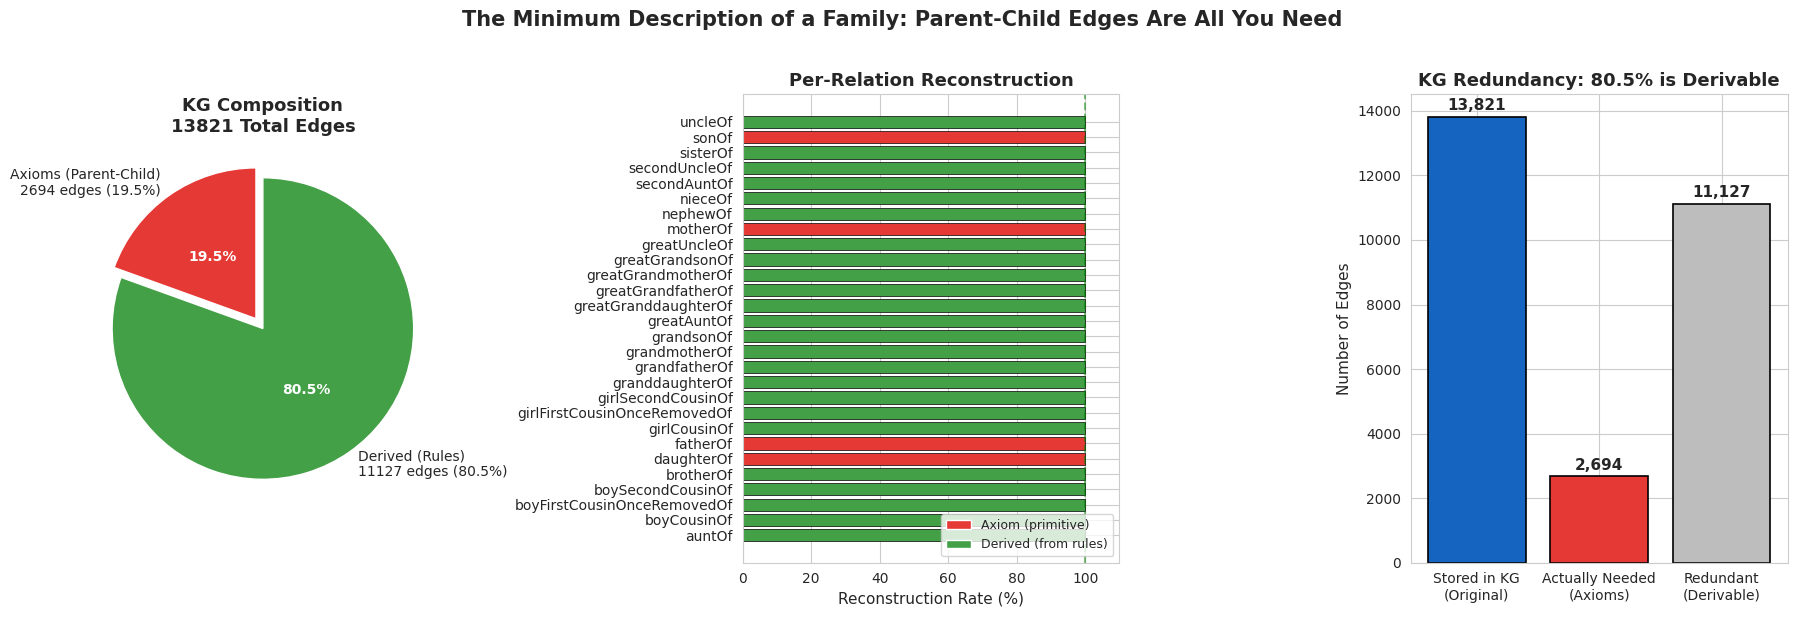


CONCLUSION

The entire MetaFam Knowledge Graph (13,821 edges, 28 relation types)
can be PERFECTLY reconstructed from just 2,694 parent-child edges
(4 relation types) + gender information.

Compression: 13,821 → 2,694 edges (19.5% of original)
Redundancy:  80.5% of the KG is logically derivable
Factor:      5.1x compression

IMPLICATION: Parent-child relationships are the ONLY primitive facts
in a family knowledge graph. Every other relationship — siblings,
grandparents, cousins, uncles, aunts — is logically derived.

This means:
1. STORAGE: Family KGs can be stored at 19.5% of their full size
2. PRIVACY: Leaking just parent-child edges exposes the ENTIRE family structure  
3. ML: Models learning on redundant edges are doing unnecessary work



In [29]:
# === VISUALIZATION: KG COMPRESSION ===

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Compression Pie Chart
compression_data = {
    f'Axioms (Parent-Child)\n{len(axiom_triples)} edges ({len(axiom_triples)/len(all_edges)*100:.1f}%)': len(axiom_triples),
    f'Derived (Rules)\n{len(all_derived_fixed)} edges ({len(all_derived_fixed)/len(all_edges)*100:.1f}%)': len(all_derived_fixed),
}
colors_pie = ['#E53935', '#43A047']
explode = (0.08, 0)
wedges, texts, autotexts = axes[0].pie(
    compression_data.values(), 
    labels=compression_data.keys(),
    autopct='%1.1f%%', startangle=90, colors=colors_pie,
    explode=explode, textprops={'fontsize': 10},
    pctdistance=0.5
)
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_color('white')
axes[0].set_title(f'KG Composition\n{len(all_edges)} Total Edges', fontsize=13, fontweight='bold')

# 2. Per-Relation Reconstruction Rate
relations = sorted(df['relation'].unique())
rates = []
actuals = []
for rel in relations:
    actual = sum(1 for h, r, t in all_edges if r == rel)
    derived = sum(1 for h, r, t in all_derived_fixed if r == rel)
    axiom = sum(1 for h, r, t in axiom_triples if r == rel)
    matched = sum(1 for h, r, t in (all_derived_fixed | axiom_triples) & all_edges if r == rel)
    rates.append(matched/actual*100 if actual else 0)
    actuals.append(actual)

colors_bar = ['#E53935' if rel in {'fatherOf','motherOf','sonOf','daughterOf'} else '#43A047' 
              for rel in relations]
axes[1].barh(relations, rates, color=colors_bar, edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('Reconstruction Rate (%)', fontsize=11)
axes[1].set_title('Per-Relation Reconstruction', fontsize=13, fontweight='bold')
axes[1].set_xlim(0, 110)
axes[1].axvline(100, color='green', linestyle='--', alpha=0.5)
# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#E53935', label='Axiom (primitive)'),
                   Patch(facecolor='#43A047', label='Derived (from rules)')]
axes[1].legend(handles=legend_elements, loc='lower right', fontsize=9)

# 3. The Punchline: What you need vs What you get
categories = ['Stored in KG\n(Original)', 'Actually Needed\n(Axioms)', 'Redundant\n(Derivable)']
values = [len(all_edges), len(axiom_triples), len(all_edges) - len(axiom_triples)]
colors_bar2 = ['#1565C0', '#E53935', '#BDBDBD']
bars = axes[2].bar(categories, values, color=colors_bar2, edgecolor='black', linewidth=1.2)
axes[2].set_ylabel('Number of Edges', fontsize=11)
axes[2].set_title(f'KG Redundancy: {(1-len(axiom_triples)/len(all_edges))*100:.1f}% is Derivable', 
                  fontsize=13, fontweight='bold')
for bar, val in zip(bars, values):
    axes[2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 100,
                 f'{val:,}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.suptitle('The Minimum Description of a Family: Parent-Child Edges Are All You Need',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Final statement
print("\n" + "=" * 70)
print("CONCLUSION")
print("=" * 70)
print(f"""
The entire MetaFam Knowledge Graph ({len(all_edges):,} edges, 28 relation types)
can be PERFECTLY reconstructed from just {len(axiom_triples):,} parent-child edges
(4 relation types) + gender information.

Compression: {len(all_edges):,} → {len(axiom_triples):,} edges ({len(axiom_triples)/len(all_edges)*100:.1f}% of original)
Redundancy:  {(1-len(axiom_triples)/len(all_edges))*100:.1f}% of the KG is logically derivable
Factor:      {len(all_edges)/len(axiom_triples):.1f}x compression

IMPLICATION: Parent-child relationships are the ONLY primitive facts
in a family knowledge graph. Every other relationship — siblings,
grandparents, cousins, uncles, aunts — is logically derived.

This means:
1. STORAGE: Family KGs can be stored at {len(axiom_triples)/len(all_edges)*100:.1f}% of their full size
2. PRIVACY: Leaking just parent-child edges exposes the ENTIRE family structure  
3. ML: Models learning on redundant edges are doing unnecessary work
""")